In [1]:
# general libraries

import itertools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import math
import time
import json
from sklearn.svm import LinearSVC
from joblib import dump, load
from numba import jit, njit
import numba

# specific libraries

from PlotToImage import PlotToImage
from auto_tsmo import full_method
from feature_extraction import getFeaturesVector
from feature_extraction import getFeatures
from FpsCounter import FpsCounter

In [2]:
# visualization functions

def ImShow(im, size=(14,17)):
    plt.figure(figsize = size)
    plt.imshow(im, 'gray')
    plt.show()

def HistPlot(vals, size=(14,17)):
    plt.figure(figsize = size)
    plt.plot(np.arange(len(vals)), vals)
    plt.show()
    
def plot_histogram(vals):
    x = list(range(len(vals)))
    ax = plt.gca()
    ax.bar(x, vals)
    ax.set_xticks(x)
    plt.show()

In [3]:
@njit('b1[:](f8[:],f8)')
def symm(array, perc):
    '''
    finds and returns high symmetry vertical regions
    '''
    array /= np.max(array)
    
    pairs = []
    for i in range(len(array)):
        for j in range(i, min(i + len(array)//3, len(array))):
            if abs(array[i]-array[j]) < perc and (array[i] != 0 and array[j] != 0):
                pairs.append([i,j])
    sym = pairs
    
    new_dens = np.ones(len(array))

    for i in range(len(sym)):
        if (sym[i][0] + sym[i][1]) % 2 == 0:
            k = int(((sym[i][1] - sym[i][0])/2) + sym[i][0])
            new_dens[k] *= 1 + (array[k]/max(array))
        else:
            k = int((((sym[i][1] - sym[i][0])/2) - .5) + sym[i][0])
            new_dens[k] *= 1 + (array[k]/max(array))
            new_dens[k+1] *= 1 + (array[k]/max(array))
    
    return new_dens > 1

In [4]:
@njit('f8[:](u1[:,:],i4,i4)')
def whiteDensity(im, n, val):
    '''
    returns histogram containing sums of HIGH ENOUGH pixels intensities column-wise
    '''
    #new_im = cv2.threshold(im, val, 255, cv2.THRESH_BINARY)[1]
    new_im = (im > val).astype(numba.int8)
    den = np.array([np.sum(np.array([np.sum(np.array([new_im[j,i] for j in range(im.shape[0])])) for i in range(k, k+n)])) for k in range(0, im.shape[1], n)])
    den = den / np.max(den)
    return den

In [5]:
@njit('f8[:](u1[:,:],i4)')
def grayDensity(im, n):
    '''
    returns histogram containing sums of pixels intensities column-wise
    '''
    new_im = im
    den = np.array([np.sum(np.array([np.sum(np.array([new_im[j,i] for j in range(im.shape[0])])) for i in range(k, k+n)])) for k in range(0, im.shape[1], n)])
    den = den / np.max(den)
    return den

In [6]:
@njit('b1(u1[:,:])')
def isCorrect(reg):
    '''
    Filtering contours by relative mean intensity value and 
    difference between the warmest and the coldest pixel intensity value
    '''
    den = grayDensity(reg, 1)
    min_val = den.min()
    int_val = reg.sum() / (reg.shape[0] * reg.shape[1])
    if min_val < 0.75:
        if int_val > 80:
            return True
    return False

In [7]:
def getRegionsAndMasks(im, im_mask, return_regions = True):
    '''
    returns regions and their coordinates (reg_masks) from image and given mask
    '''
    reg_masks = []
    mask = []
    for i, s in enumerate(im_mask):
        if s:
            mask.extend([i])
        else:
            if len(mask) > 5:
                reg_masks.append(mask)
            mask = []
    if len(mask) > 10:
        reg_masks.append(mask)
    if not return_regions:
        return reg_masks
    regions = [np.array([[im[i,j] for j in mask] for i in range(im.shape[0])], dtype=np.uint8) for mask in reg_masks]
    return regions, reg_masks

In [8]:
gts_folder = "Groundtruth_Markup//"

In [9]:
video_dataset = {}
with open(gts_folder + "VIDEO_val_groundtruth.json", "r") as read_file:
    video_dataset = json.load(read_file)
    
FLIR_dataset = {}
with open(gts_folder + "FLIR_val_groundtruth.json", "r") as read_file:
    FLIR_dataset = json.load(read_file)

In [10]:
# video_dataset = {}
# with open(gts_folder + "VIDEO_train_groundtruth.json", "r") as read_file:
#     video_dataset = json.load(read_file)
    
# FLIR_dataset = {}
# with open(gts_folder + "FLIR_train_groundtruth.json", "r") as read_file:
#     FLIR_dataset = json.load(read_file)

In [11]:
video_model = load('video_classifier')
FLIR_model = load('FLIR_classifier')

In [ ]:
from skimage.filters import threshold_multiotsu
import cv2

image = cv2.imread(r'C:\Users\Yuriy\Downloads\4a\img_00041.bmp', 0)

thresholds = threshold_multiotsu(image, classes = 2)
print(thresholds)
thresholds = threshold_multiotsu(image, classes = 3)
print(thresholds)
thresholds = threshold_multiotsu(image, classes = 4)
print(thresholds)

In [ ]:
filtered_cnts = []

thresh = cv2.threshold(...,142, )

kernel = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]], np.uint8)

thresh = cv2.dilate(thresh, kernel, iterations=1)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if not (w > 10 and h > 20 and h / w > 0.5 and h / w < 3):
        continue
    filtered_cnts.append([x,y,w,h])

In [12]:
def getRects(regions, reg_masks):
    '''
    finds and returns filtered rects (ROIs) from all vertical regions
    '''
    filtered_cnts = []
    for i, reg in enumerate(regions):
        thresholds, masks = full_method(reg, L = 2**8, M=128)
        thresh = (((masks[-2]+masks[-1])*255)).astype(np.uint8)
#         kernel = np.ones((3,3), np.uint8); thresh = cv2.dilate(thresh, kernel, iterations=10) 
#         kernel = np.array([[0.01, 1, 0.01], [0.01, 0.01, 0.01], [0.01, 1, 0.01]], np.float32);thresh = cv2.dilate(thresh, kernel, iterations=13)
    
        kernel = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]], np.uint8);thresh = cv2.dilate(thresh, kernel, iterations=15)
        kernel = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]], np.uint8);thresh = cv2.dilate(thresh, kernel, iterations=10)
    
#         ImShow(reg)
#         ImShow(thresh)
        
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            if not (w > 10 and h > 20 and h / w > 0.5 and h / w < 3):
                continue
            if not isCorrect(reg[y:y+h,x:x+w]):
                continue
            x += reg_masks[i][0]
            filtered_cnts.append([x,y,w,h])
            
    return filtered_cnts 

def filterRects(im_path, rects, video_or_FLIR):
    '''
    returns rects filtered by corresponding classifier
    '''
    if video_or_FLIR == 'video':
        model = video_model
    elif video_or_FLIR == 'FLIR':
        model = FLIR_model
    else:
        model = None
    true_rects = []
    for rect in rects:
        if bool(model.predict(getFeatures((im_path, rect), True, True))):
            true_rects.append(rect)
    return true_rects

In [13]:
def drawRects(frame, rects):
    '''
    draws rects on given frame
    '''
    for rect in rects:
        x,y,w,h = rect
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)

def saveRects(rects, im_path, predictions):
    '''
    adds rects to given dict
    '''
    for rect in rects:
        if im_path in predictions:
            predictions[im_path].append(rect)
        else:
            predictions[im_path] = []
            predictions[im_path].append(rect)

In [14]:
@njit('b1[:](u1[:,:],i8)')
def getSymm_(im, thresh_val):
    '''
    finds symmetry on given image and returns symmetry mask and corresponding image
    '''
    N = 8
    den = whiteDensity(im, n = N, val = thresh_val)  

    sym = symm(den, 0.1)
    sym = np.array([[sym[i] for j in range(N)] for i in range(len(sym))]).reshape(-1,) 
    
    return sym

In [15]:
def getSymm(im):
    '''
    finds symmetry on given image and returns symmetry mask and corresponding image
    '''
    thresholds, masks = full_method(im, L = 2**8, M=128)
    thresh_val = thresholds[-1]

    return getSymm_(im, thresh_val)

In [16]:
def getSymmImage(im, sym):
    '''
    finds symmetry on given image and returns symmetry mask and corresponding image
    '''
    sym_im = np.array([[im[i,j] for j in range(im.shape[1])]*sym for i in range(im.shape[0])], dtype = np.uint8)
    
    return sym_im

In [17]:
def add_text_to_frame(frame, text):
    '''
    draws given text on given frame
    '''
    cv2.putText(frame, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), lineType=cv2.LINE_AA)

In [18]:
im = cv2.imread(r'C:\Users\Yuriy\Downloads\FLIR\FLIR_ADAS\validation\PreviewData\FLIR_08916.jpeg', 0)
im = cv2.resize(im, (im.shape[1] // 2, im.shape[0] // 2))
plt.imshow(im, 'gray')

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
im = cv2.imread(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\Frames\video_frame_1375.jpeg', 0)
sym = getSymm(im)

In [ ]:
im = cv2.resize(im, (im.shape[1] // 2, im.shape[0] // 2))

In [ ]:
im.shape

In [ ]:
(im.shape[0] // 2, im.shape[1] // 2)

In [ ]:
plt.imshow(im, 'gray')

In [2]:
from HistogramOfOpticalFlow import hof

In [16]:
im1 = cv2.imread(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\Frames\video_frame_1375.jpeg', 0)
im2 = cv2.imread(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\Frames\video_frame_1376.jpeg', 0)

In [17]:
part1 = im1[240:-40,660:840]
part2 = im2[240:-40,660:840]

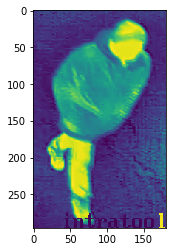

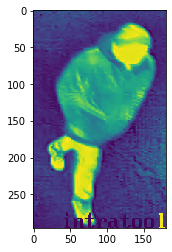

In [18]:
plt.imshow(part1)
plt.show()
plt.imshow(part2)
plt.show()

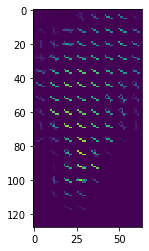

In [19]:
width = 64
height = 128

resized1 = cv2.resize(part1, (width, height), interpolation = cv2.INTER_LINEAR)
resized2 = cv2.resize(part2, (width, height), interpolation = cv2.INTER_LINEAR)

flow = cv2.calcOpticalFlowFarneback(resized1, resized2, flow=None, pyr_scale=.5, 
            levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, 
                                    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

plt.imshow(hof(flow, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise = True)[1])

In [23]:
def getHOOF(im_path1, im_path2, cnt):
    x,y,w,h = cnt
    part1 = cv2.imread(im_path1, 0)[y:y+h,x:x+w]
    part2 = cv2.imread(im_path2, 0)[y:y+h,x:x+w]
    
    width = 64
    height = 128
    
    resized1 = cv2.resize(part1, (width, height), interpolation = cv2.INTER_LINEAR)
    resized2 = cv2.resize(part2, (width, height), interpolation = cv2.INTER_LINEAR)
    
    flow = cv2.calcOpticalFlowFarneback(resized1, resized2, flow=None, pyr_scale=.5, 
                levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, 
                                        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    
    return hof(flow, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

In [30]:
getHOOF(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\Frames\video_frame_1375.jpeg', 
        r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\Frames\video_frame_1376.jpeg',
        (100,100,50,60))

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.20608026])

In [47]:
import numpy as np
import cv2

cap = cv2.VideoCapture(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\video.mp4')

lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0,255,(100,3))

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

mask = np.zeros_like(old_frame)


p = np.zeros_like(p0)
p[0][0][:] = [530, 120]
p[1][0][:] = [600, 200]
p[2][0][:] = [700, 250]
p = p[0:3]

# it = 0 
while(1):
    
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     it +=1
#     if it < 8000:
#         continue

    # calculate optical flow
    

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [42]:
p = np.zeros_like(p0)
p = p[0:1]
p[0][0][:] = [100, 200]
p

array([[[100., 200.]]], dtype=float32)

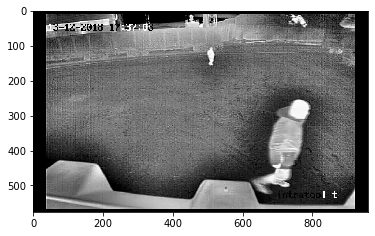

In [36]:
plt.imshow(old_gray, 'gray')

In [26]:
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
p0.shape

(46, 1, 2)

In [45]:
import numpy as np
import cv2

cap = cv2.VideoCapture(r'C:\Users\Yuriy\Dropbox\Project&Practice\HumanDetection\VIDEO_Dataset\video.mp4')



# params for ShiTomasi corner detection
# feature_params = dict( maxCorners = 100,
#                        qualityLevel = 0.3,
#                        minDistance = 7,
#                        blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

KeyboardInterrupt: 

In [19]:
def normalSize(rects, frame, im):
    height_ratio = frame.shape[0] / im.shape[0]
    width_ratio = frame.shape[1] / im.shape[1]
    
    new_rects = []
    
    for (x,y,w,h) in rects:
        x_max, y_max = x + w, y + h
        
        new_x = int(np.round(x * width_ratio))
        new_y = int(np.round(y * height_ratio))
        
        new_x_max = int(np.round(x_max * width_ratio))
        new_y_max = int(np.round(y_max * height_ratio))
        
        new_rects.append((new_x, new_y, new_x_max - new_x, new_y_max - new_y))
        
    return new_rects

In [20]:
def Predict(dataset, SVM_filter = True, start_index = 0, end_index = None, show_fps = False, 
            show_blank_frame = True, show_symm_im = False, 
            time_between_frames = 1000, write_to_file = False, show_frame_index = True,
            return_preds = False, resize = False):
    
    predictions = {}
    
    fps = FpsCounter()

    index = -1
    
    dataset_keys = []
    if dataset == 'VIDEO':
        dataset_keys = list(video_dataset.keys())
    elif dataset == 'FLIR':
        dataset_keys = list(FLIR_dataset.keys())
    else:
        assert(False)
    
    
    for im_path in dataset_keys:
        if show_fps:
            fps.start()
        
        index += 1
        if (index < start_index):
            continue
            
        frame = cv2.imread(im_path)
        
#         frame = cv2.resize(frame, (frame.shape[1] // 2, frame.shape[0] // 2))

        im = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        if resize:
            k = 1
            new_width = int(im.shape[1] / k)
            new_width -= new_width % 8
            
            new_height = int(im.shape[0] / k)
            new_height -= new_height % 8
            
            im = cv2.resize(im, (new_width, new_height))
        
        if show_blank_frame:
            cv2.imshow("im", im)

        sym = getSymm(im)
        
        if show_symm_im:
            sym_im = getSymmImage(im, sym)
            cv2.imshow("symm_im", sym_im)
            
        regions, reg_masks = getRegionsAndMasks(im, sym)
        
        rects = getRects(regions, reg_masks)
        
        if SVM_filter:
            if dataset == 'VIDEO':
                rects = filterRects(im_path, rects, 'video')
            elif dataset == 'FLIR':
                rects = filterRects(im_path, rects, 'FLIR')
            else:
                assert(False)
                
        if resize:
            rects = normalSize(rects, frame, im)
            
        drawRects(frame, rects)
        
        saveRects(rects, im_path, predictions)

        if show_fps:
            fps.add_fps(frame)
        
        if show_frame_index:
            add_text_to_frame(frame, im_path[-21:])
            
        cv2.imshow('frame', frame)

        if cv2.waitKey(time_between_frames) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    
    if write_to_file:
        if dataset == 'VIDEO':
            if SVM_filter:
                with open(preds_folder + 'VIDEO_val_predictions_SVM.json', 'w') as outfile:
                    json.dump(predictions, outfile)
            else:
                with open(preds_folder + 'VIDEO_val_predictions.json', 'w') as outfile:
                    json.dump(predictions, outfile)
        elif dataset == 'FLIR':
            if SVM_filter:
                with open(preds_folder + 'FLIR_val_predictions_SVM.json', 'w') as outfile:
                    json.dump(predictions, outfile)
            else:
                with open(preds_folder + 'FLIR_val_predictions.json', 'w') as outfile:
                    json.dump(predictions, outfile)
        else:
            assert(False)
    
    if return_preds:
        return predictions

In [21]:
predictions = Predict(dataset = 'FLIR', SVM_filter = False, start_index = 0, end_index = None, show_fps = True, 
        show_blank_frame = True, show_symm_im = False, 
        time_between_frames = 1, write_to_file = False, show_frame_index = True, 
        return_preds = True, resize = False)

In [157]:
with open(preds_folder + 'VIDEO_val_predictions_TSMO_exp1.json', 'w') as outfile:
    json.dump(predictions, outfile)

In [137]:
predictions = Predict(dataset = 'FLIR', SVM_filter = False, start_index = 0, end_index = None, show_fps = True, 
        show_blank_frame = True, show_symm_im = False, 
        time_between_frames = 1, write_to_file = False, show_frame_index = True, 
        return_preds = True, resize = False)

In [138]:
with open(preds_folder + 'FLIR_val_predictions_TSMO_exp.json', 'w') as outfile:
    json.dump(predictions, outfile)

In [ ]:
##################

In [ ]:
# Just plain SSD Neural Network

In [20]:
import os
import sys
import tensorflow as tf

In [21]:
def plain_SSD_predict(dataset, write_to_file = False):
    path = r'C:\Users\Yuriy\Net2//'
    
    if dataset == 'VIDEO':
        PATH_TO_CKPT = path + '/ssd_mobilenet_v2_coco_2020_02_02/frozen_inference_graph.pb'
        dataset_keys = list(video_dataset.keys())
    elif dataset == 'FLIR':
        PATH_TO_CKPT = path + '/ssd_mobilenet_v2_coco_2020_02_17/frozen_inference_graph.pb'
        dataset_keys = list(FLIR_dataset.keys())
    else:
        assert(False)

    predictions = {}

    fps = FpsCounter()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            for im_path in dataset_keys:
                fps.start()
                frame = cv2.imread(im_path)
                cv2.imshow("frame", frame)

                rows = frame.shape[0]
                cols = frame.shape[1]
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(frame, axis=0)
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                # Each box represents a part of the image where a particular object was detected.
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                # Each score represent how level of confidence for each of the objects.
                # Score is shown on the result image, together with the class label.
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                # Using Actual detection.
                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes, scores, classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                #print("detected = "+str(num_detections[0]))
                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                # Visualize only detected boxes

                rects = []

                if (num_detections>0):
                    for i in range(0,int(num_detections[0])):
                        # Check scores for visualise
                        if scores[i] < 0.2:
                            continue
                        detection = boxes[i]
                        #print(str(detection) +' score='+ str(scores[i] ) + ' cols='+str(cols) + ' rows='+str(rows))
                        left = detection[1] * cols
                        top = detection[0] * rows
                        right = detection[3] * cols
                        bottom = detection[2] * rows
                        rects.append([int(left), int(top), int(right) - int(left), int(bottom) - int(top)])
                        cv2.rectangle(frame, (int(left), int(top)), (int(right), int(bottom)), (23, 230, 210), thickness=2)

                drawRects(frame, rects)

                saveRects(rects, im_path, predictions)

                fps.add_fps(frame)

                cv2.imshow('frame', frame)

                if cv2.waitKey(100) & 0xFF == ord('q'):
                    break

            cv2.destroyAllWindows()    
    
    if write_to_file:
        if dataset == 'VIDEO':
            with open(preds_folder + 'VIDEO_val_predictions_SSD.json', 'w') as outfile:
                json.dump(predictions, outfile)
        elif dataset == 'FLIR':
            with open(preds_folder + 'FLIR_val_predictions_SSD.json', 'w') as outfile:
                json.dump(predictions, outfile)
        else:
            assert(False)
        
    return predictions

In [22]:
predictions = plain_SSD_predict('FLIR')

In [23]:
def TSMO_SSD_predict(dataset, write_to_file = False):
    path = r'C:\Users\Yuriy\Net2//'

    if dataset == 'VIDEO':
        PATH_TO_CKPT = path + '/ssd_mobilenet_v2_coco_2020_02_02/frozen_inference_graph.pb'
        dataset_keys = list(video_dataset.keys())
    elif dataset == 'FLIR':
        PATH_TO_CKPT = path + '/ssd_mobilenet_v2_coco_2020_02_17/frozen_inference_graph.pb'
        dataset_keys = list(FLIR_dataset.keys())
    else:
        assert(False)

    predictions = {}

    fps = FpsCounter()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            ind = -1
            for im_path in dataset_keys:
                fps.start()
                ind += 1
                if (ind < 0):
                    continue
                frame = cv2.imread(im_path)
                im = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                cv2.imshow("im", im)


                thresholds, masks = full_method(im, L = 2**8, M=128)
                N = 8
                thresh_val = thresholds[-1]
                den = whiteDensity(im, n = N, val = thresh_val)  

                sym = symm(den, 0.1)
                sym = np.array([[sym[i] for j in range(N)] for i in range(len(sym))]).reshape(-1,) 
            #     sym = getImMask(im)
                sym_im = np.array([[im[i,j] for j in range(im.shape[1])]*sym for i in range(im.shape[0])], dtype = np.uint8)
                cv2.imshow("symm_im", sym_im)



                regions, reg_masks = getRegionsAndMasks(im, sym)
                rects = getRects(regions, reg_masks)        

                frame_= frame.copy()
                true_rects = []
                for (x, y, w, h) in rects:
                    frame = frame[y : y + h, x : x + w]
                    rows = frame.shape[0]
                    cols = frame.shape[1]
                    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(frame, axis=0)
                    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                    # Each box represents a part of the image where a particular object was detected.
                    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                    # Each score represent how level of confidence for each of the objects.
                    # Score is shown on the result image, together with the class label.
                    scores = detection_graph.get_tensor_by_name('detection_scores:0')
                    classes = detection_graph.get_tensor_by_name('detection_classes:0')
                    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                    # Using Actual detection.
                    (boxes, scores, classes, num_detections) = sess.run(
                        [boxes, scores, classes, num_detections],
                        feed_dict={image_tensor: image_np_expanded})
                    scores = np.squeeze(scores)

                    if (num_detections>0):
                        for i in range(0,int(num_detections[0])):
                            if scores[i] < 0.2 :
                                continue
                            true_rects.append((x, y, w, h))

                    frame = frame_.copy()
                rects = true_rects
                drawRects(frame, rects)
                saveRects(rects, im_path, predictions)

            #     drawContours(frame, regions, reg_masks)    
                fps.add_fps(frame)
                cv2.imshow('frame', frame)


                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cv2.destroyAllWindows() 
            
    if write_to_file:
        if dataset == 'VIDEO':
            with open(preds_folder + 'VIDEO_val_predictions_SSD.json', 'w') as outfile:
                json.dump(predictions, outfile)
        elif dataset == 'FLIR':
            with open(preds_folder + 'FLIR_val_predictions_SSD.json', 'w') as outfile:
                json.dump(predictions, outfile)
        else:
            assert(False)
        
    return predictions

In [24]:
predictions = TSMO_SSD_predict('FLIR')

In [ ]:
with open(preds_folder + 'VIDEO_val_predictions_TSMO_SSD.json', 'w') as outfile:
    json.dump(predictions, outfile)